In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import sys

sys.path.append("/home/stachu/Projects/Anomaly_detection/Forecasting_models")

from predpy.dataset import MultiTimeSeriesDataset, MultiTimeSeriesDataloader
from predpy.data_module import MultiTimeSeriesModule
from predpy.wrapper import Autoencoder, Predictor, VAE, PAE, PVAE
from predpy.experimentator import (
    DatasetParams, ModelParams,
    Experimentator, load_experimentator)
from predpy.preprocessing import set_index
from predpy.preprocessing import moving_average
from predpy.preprocessing import (
    load_and_preprocess, set_index, moving_average, drop_if_is_in,
    use_dataframe_func, loc, iloc, get_isoforest_filter, get_variance_filter)
from predpy.trainer import (
    CheckpointParams, TrainerParams, EarlyStoppingParams, LoggerParams,
    get_trained_pl_model)
from tsad.noiser import apply_noise_on_dataframes, white_noise
from tsad.anomaly_detector import (
    PredictionAnomalyDetector, ReconstructionAnomalyDetector,
    EmbeddingAnomalyDetector, ReconstructionDistributionAnomalyDetector,
    ReconstructionAndEmbeddingAnomalyDetector)
from tsad.error_regressor import NNRegressor
from models import LSTMAE, LSTMVAE, LSTMPAE, LSTMPVAE

from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl
import pickle
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# from tsai.models import TCN, ResNet, TST, RNN, TransformerModel, FCN
import pandas as pd
from torch.utils.data import DataLoader, Dataset
# from prophet import Prophet

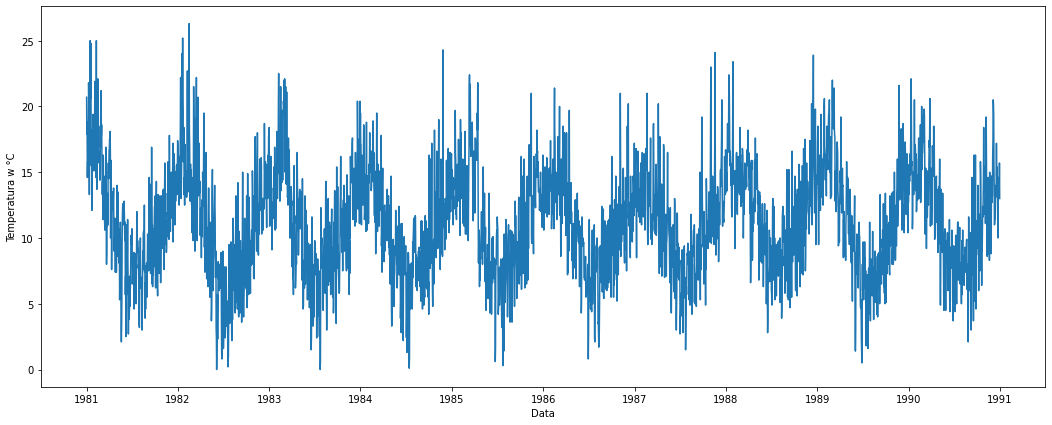

In [4]:
df = pd.read_csv("../data/Meteorology/daily-min-temperatures.csv")

df["Date"] = pd.to_datetime(df['Date'])
df = df.set_index("Date")
# df.groupby(pd.Grouper(freq="M")).mean().plot(ax=ax)
# df.groupby([(df.index.year),(df.index.month)])

fig, ax = plt.subplots(figsize=(18, 7))
ax.set_xlabel("Data")
ax.set_ylabel("Temperatura w °C")
ax.plot(df.index, df["Temp"]);

In [3]:
# ds_path = "../data/Energy/" + "household_power_consumption/household_power_consumption.csv"
# load_params = {
#     "sep": ';', "header": 0, "low_memory": False,
#     "infer_datetime_format": True, "parse_dates": {'datetime': [0, 1]},
#     "index_col": ['datetime']
# }
# pipeline = [
#     (drop_if_is_in, (["?", np.nan]), {"columns": ["Global_active_power"]}),
#     (use_dataframe_func, "astype", "float"),
#     # (select_columns, ["Global_active_power"])
# ]

# df = load_and_preprocess(ds_path, load_params, pipeline)

In [10]:

mean_ = df_cut["vals"].mean()
std_ = 3
df_cut["vals"].apply(lambda x: mean_ + (x - mean_) * std_)

0      9.786526
1      9.525415
2      7.632359
3      7.371248
4      4.890692
         ...   
645    7.893470
646    7.632359
647    7.567081
648    9.003192
649    7.240692
Name: vals, Length: 650, dtype: float64

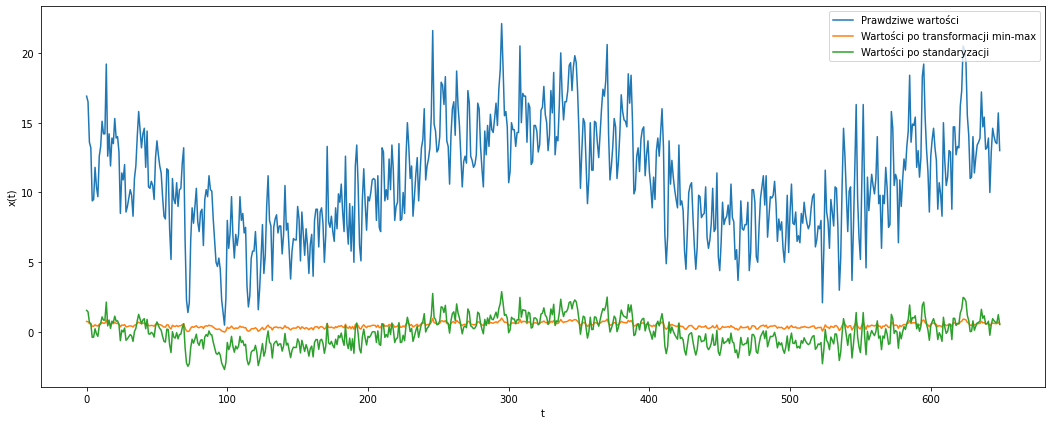

In [16]:
df_cut = df[["Temp"]][3000:4000]
df_cut = df_cut.rename(columns={"Temp": "vals"})

df_cut["normalized"] = (df_cut["vals"] - df_cut["vals"].min()) / (df_cut["vals"].max() - df_cut["vals"].min())
# df_cut["vals"] = df_cut["normalized"] * (8.3 - 3.6) + 3.6
# df_cut["normalized"] = df_cut["normalized"] * (1 - -1) + -1
df_cut["standarized"] = (df_cut["vals"] - df_cut["vals"].mean()) / df_cut["vals"].std()
df_cut = df_cut.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(18, 7))
# ax.set_xlabel("Data")
ax.plot(df_cut.index, df_cut["vals"], label="Prawdziwe wartości")
ax.plot(df_cut.index, df_cut["normalized"], label="Wartości po transformacji min-max")
ax.plot(df_cut.index, df_cut["standarized"], label="Wartości po standaryzacji")
ax.set_xlabel("t")
ax.set_ylabel("x(t)")
ax.legend(loc="upper right");

Text(0, 0.5, 'y(t)')

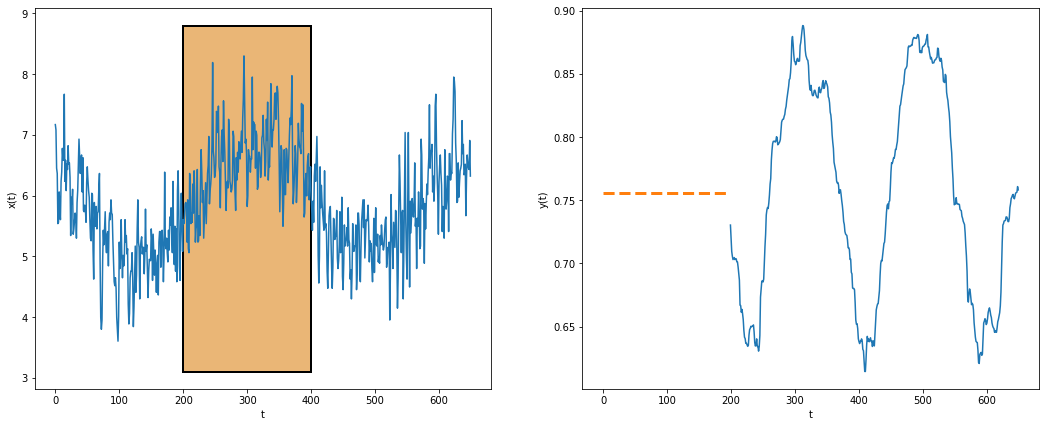

In [7]:
from matplotlib.patches import Rectangle
  
df = df_cut[:]
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
window_size = 200
axs[0].plot(df.index, df["vals"])
axs[0].add_patch( Rectangle((200, df["vals"].min() - 0.5),
                        window_size, df["vals"].max() - df["vals"].min() + 1,
                        fc ='#eab676', 
                        ec ='black',
                        lw = 2) )

mean = df.rolling(window_size).std().dropna()

axs[1].plot(mean.index, mean["vals"])
axs[1].plot(list(range(window_size)), [mean["vals"].mean()]*window_size, "--", lw=3)
axs[1].set_xlim(axs[0].get_xlim())
axs[0].set_xlabel("t")
axs[0].set_ylabel("x(t)")
axs[1].set_xlabel("t")
axs[1].set_ylabel("y(t)")

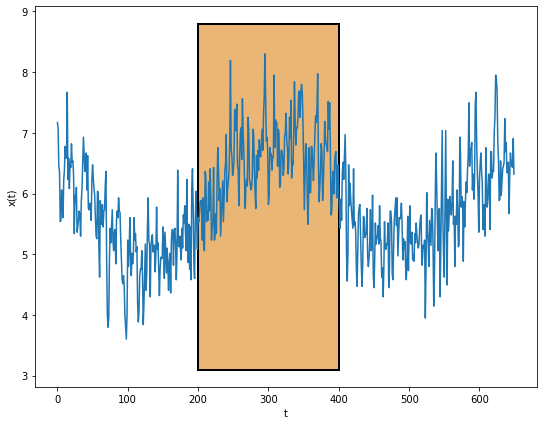

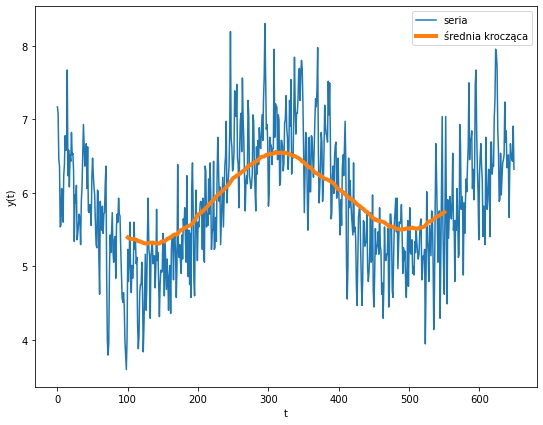

In [19]:
fig, ax = plt.subplots(figsize=(9, 7))
window_size = 200
ax.plot(df.index, df["vals"])
ax.add_patch( Rectangle((200, df["vals"].min() - 0.5),
                        window_size, df["vals"].max() - df["vals"].min() + 1,
                        fc ='#eab676', 
                        ec ='black',
                        lw = 2) )

ax.set_xlabel("t")
ax.set_ylabel("x(t)")
plt.show()

fig, ax = plt.subplots(figsize=(9, 7))
mean = df.rolling(window_size, center=True).mean().dropna()

ax.plot(df.index, df["vals"], label="seria")
ax.plot(mean.index, mean["vals"], lw=4, label="średnia krocząca")
# ax.plot(list(range(window_size)), [mean["vals"].mean()]*window_size, "--", lw=3)
ax.set_xlim(axs[0].get_xlim())
ax.set_xlabel("t")
ax.set_ylabel("y(t)")
ax.legend();

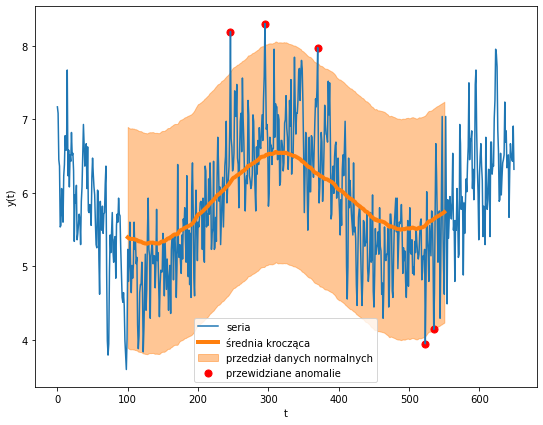

In [50]:
fig, ax = plt.subplots(figsize=(9, 7))
mean = df.rolling(window_size, center=True).mean().dropna()

ax.plot(df.index, df["vals"], label="seria")
ax.plot(mean.index, mean["vals"], lw=4, label="średnia krocząca")
ax.fill_between(mean.index, mean["vals"] + 1.5, mean["vals"] - 1.5, color="#ff7f0e70", label="przedział danych normalnych")

anomalies = df.loc[mean.index][
    (df.loc[mean.index]["vals"] > mean["vals"] + 1.5)
    | (df.loc[mean.index]["vals"] < mean["vals"] - 1.5)]["vals"]
ax.scatter(anomalies.index, anomalies, c="r", s=50, label="przewidziane anomalie")
# ax.plot(list(range(window_size)), [mean["vals"].mean()]*window_size, "--", lw=3)
ax.set_xlim(axs[0].get_xlim())
ax.set_xlabel("t")
ax.set_ylabel("y(t)")
ax.legend();


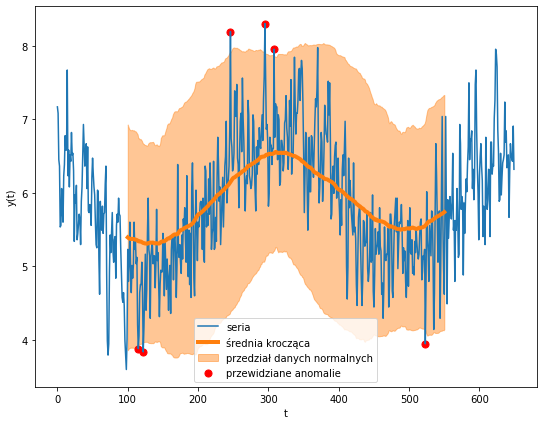

In [69]:
fig, ax = plt.subplots(figsize=(9, 7))
mean = df.rolling(window_size, center=True).mean().dropna()["vals"]
std = df.rolling(window_size, center=True).std().dropna()["vals"]
D=2.1

ax.plot(df.index, df["vals"], label="seria")
ax.plot(mean.index, mean, lw=4, label="średnia krocząca")
ax.fill_between(mean.index, mean + D*std, mean - D*std, color="#ff7f0e70", label="przedział danych normalnych")

anomalies = df.loc[mean.index][
    (df.loc[mean.index, "vals"] > mean + D*std)
    | (df.loc[mean.index, "vals"] < mean - D*std)]["vals"]
ax.scatter(anomalies.index, anomalies, c="r", s=50, label="przewidziane anomalie")
# ax.plot(list(range(window_size)), [mean["vals"].mean()]*window_size, "--", lw=3)
ax.set_xlim(axs[0].get_xlim())
ax.set_xlabel("t")
ax.set_ylabel("y(t)")
ax.legend();


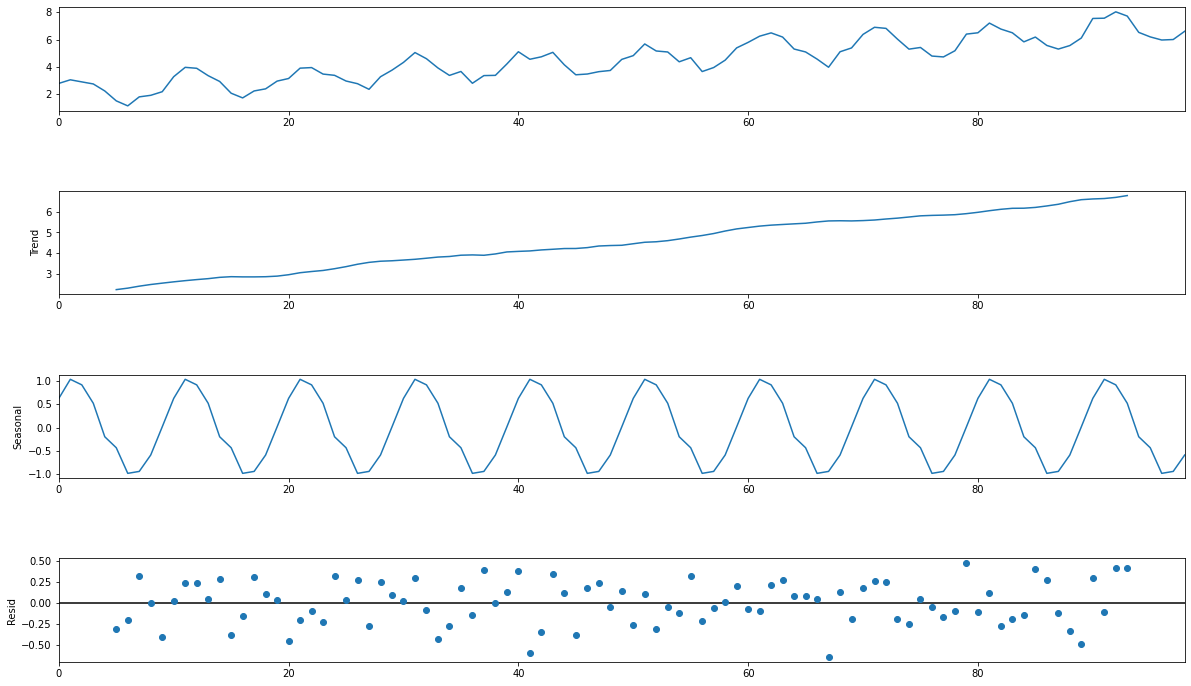

In [14]:

from statsmodels.tsa.seasonal import seasonal_decompose
# df = pd.read_csv("../data/Meteorology/daily-min-temperatures.csv")

# # fig, ax = plt.subplots(figsize=(9, 7))
# df["Date"] = pd.to_datetime(df['Date'])
# df = df.iloc[:500]
# df = df.set_index("Date")
# df = df.asfreq(freq='1d', fill_value=50)
# series = df["Temp"]
t = np.arange(1, 100)

series = pd.Series(5e-2*t + np.sin(0.2*np.pi*t) + 1.5 + np.random.rand(len(t)))#, index=pd.date_range('20130101 09:00:00', freq='1d', periods=periods))

result = seasonal_decompose(series, model='additive', period=10)
fig = result.plot().set_size_inches(18.5, 10.5)

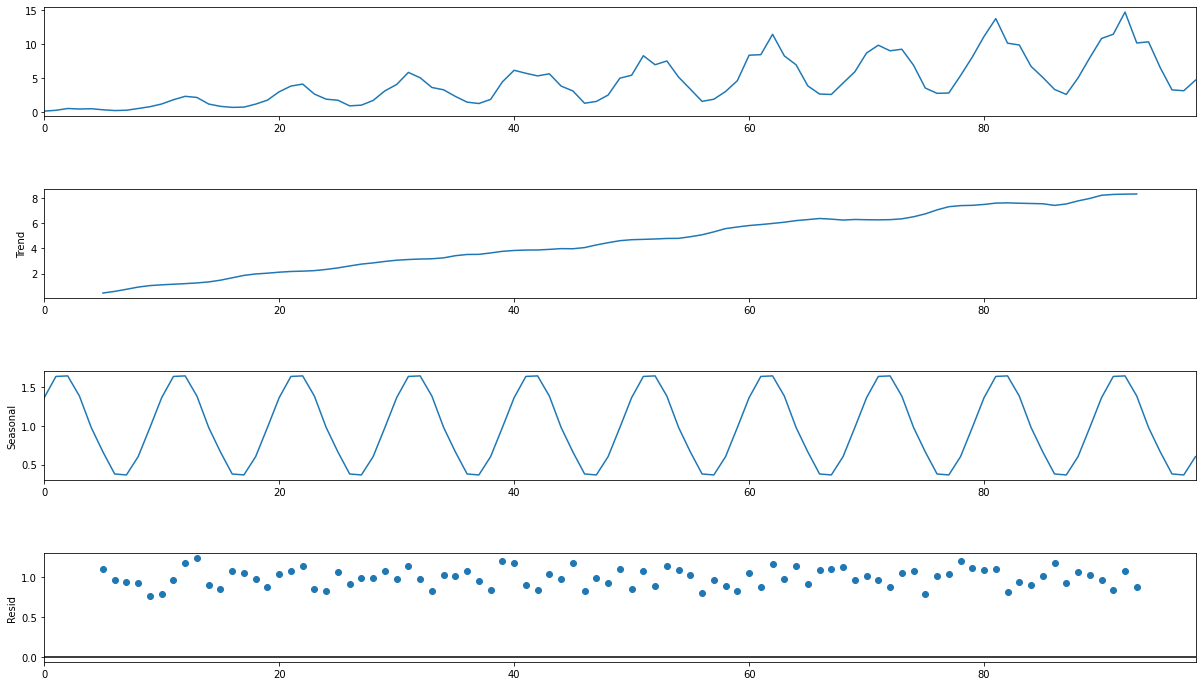

In [17]:

from statsmodels.tsa.seasonal import seasonal_decompose
# df = pd.read_csv("../data/Meteorology/daily-min-temperatures.csv")

# # fig, ax = plt.subplots(figsize=(9, 7))
# df["Date"] = pd.to_datetime(df['Date'])
# df = df.iloc[:500]
# df = df.set_index("Date")
# df = df.asfreq(freq='1d', fill_value=50)
# series = df["Temp"]
t = np.arange(1, 100)

series = pd.Series(5e-2*t*(np.sin(0.2*np.pi*t) + 1.5)*(1 + 5e-1*np.random.rand(len(t))))
result = seasonal_decompose(series, model='multiplicative', period=10)
fig = result.plot().set_size_inches(18.5, 10.5)

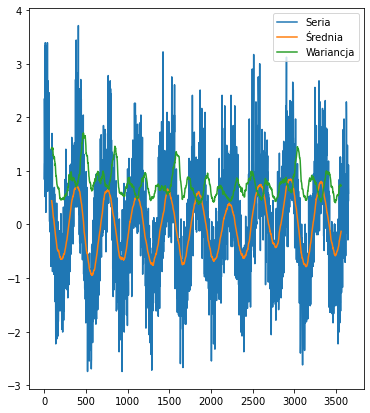

In [71]:
df = pd.read_csv("../data/Meteorology/daily-min-temperatures.csv")

df["Date"] = pd.to_datetime(df['Date'])
# df = df.set_index("Date")
df = df.drop(columns="Date")
df = df.iloc[:5000]
df = df.rename(columns={"Temp": "Seria"})
w_s = 180

df["Seria"] = (df["Seria"] - df["Seria"].mean())/df["Seria"].std()
df["Średnia"] = df["Seria"].rolling(w_s, center=True).mean()
df["Wariancja"] = df["Seria"].rolling(w_s, center=True).var()
# df["Wariancja"] = df["Temp"].rolling(w_s, center=True).cov()

fig, ax = plt.subplots(figsize=(6, 7))
df.plot(ax=ax);

# fig, ax = plt.subplots(figsize=(6, 7))
# df["Temp"].plot(ax=ax)

# fig, ax = plt.subplots(figsize=(6, 7))
# df["diff"].plot(ax=ax);

# fig, ax = plt.subplots(figsize=(6, 7))
# df[["mean", "var"]].plot(ax=ax);

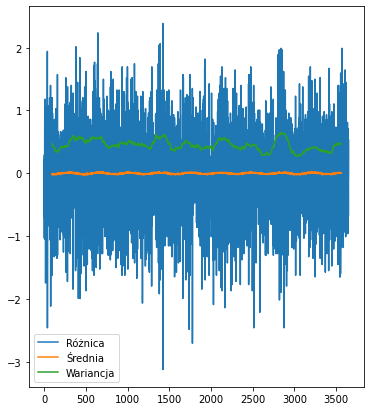

In [72]:
df = pd.read_csv("../data/Meteorology/daily-min-temperatures.csv")

df["Date"] = pd.to_datetime(df['Date'])
# df = df.set_index("Date")
df = df.drop(columns="Date")
df = df.iloc[:5000]
df = df.rename(columns={"Temp": "Seria"})
w_s = 180

df["Seria"] = (df["Seria"] - df["Seria"].mean())/df["Seria"].std()
df["Seria"] = df["Seria"].diff()
df["Średnia"] = df["Seria"].rolling(w_s, center=True).mean()
df["Wariancja"] = df["Seria"].rolling(w_s, center=True).var()
# df["cov"] = df["Temp"].rolling(w_s, center=True).cov()
df = df.rename(columns={"Seria": "Różnica"})

fig, ax = plt.subplots(figsize=(6, 7))
df.plot(ax=ax);

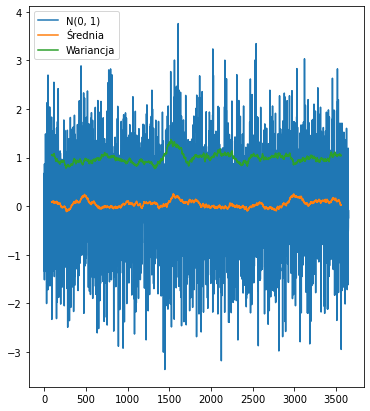

In [73]:
df = pd.read_csv("../data/Meteorology/daily-min-temperatures.csv")

df["Date"] = pd.to_datetime(df['Date'])
# df = df.set_index("Date")
df = df.drop(columns="Date")
df = df.iloc[:5000]
w_s = 180

df = pd.DataFrame(np.random.randn(df.shape[0]), columns=["N(0, 1)"])
df["Średnia"] = df["N(0, 1)"].rolling(w_s, center=True).mean()
df["Wariancja"] = df["N(0, 1)"].rolling(w_s, center=True).var()
# df["cov"] = df["Temp"].rolling(w_s, center=True).cov()

fig, ax = plt.subplots(figsize=(6, 7))
df.plot(ax=ax);

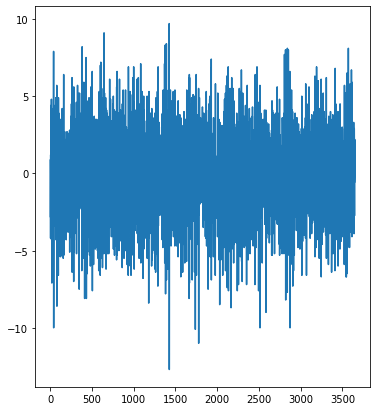

In [8]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
df = pd.read_csv("../data/Meteorology/daily-min-temperatures.csv")

df["Date"] = pd.to_datetime(df['Date'])
# df = df.set_index("Date")
df = df.drop(columns="Date")
df = df.iloc[:5000]
df = df.rename(columns={"Temp": "Seria"})
w_s = 180
t = np.arange(1,100)

# vals = [1, 1, 1]
# for i in range(3, 1003):
#     vals += [0.27 * vals[i-3] - 0.35 * vals[i-2] + 1 * vals[i-1] + 0.3*np.random.randn()]
# df = pd.DataFrame(vals[3:], columns=["Seria"])
# df = pd.DataFrame(5e-2*t + np.sin(0.2*np.pi*t) + 1.5 + np.random.rand(len(t)), columns=["Seria"])
# df = pd.DataFrame(5e-3*t*(np.sin(0.2*np.pi*t) + 1.5)*(1 + 5e-1*np.random.rand(len(t))), columns=["Seria"])

# df["Seria"] = (df["Seria"] - df["Seria"].mean())/df["Seria"].std()
df["Seria"] = df["Seria"].diff()
df = df.dropna(axis=0)

fig, ax = plt.subplots(figsize=(6, 7))
ax.plot(df.index, df["Seria"]);

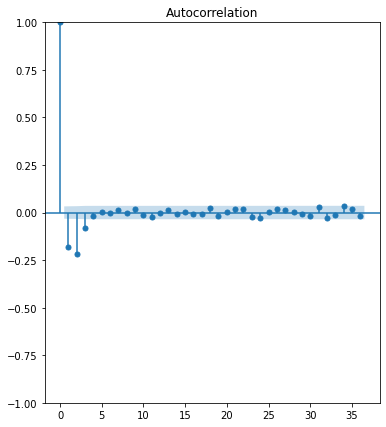

In [9]:
fig = plot_acf(df["Seria"])
fig.set_size_inches(6, 7)
plt.show();

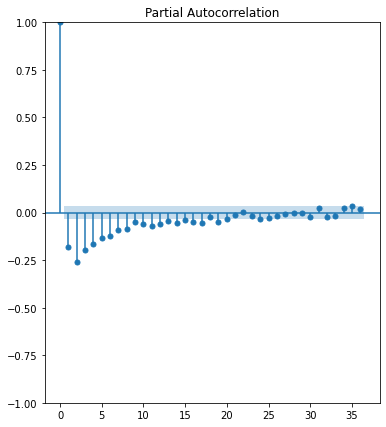

In [10]:
fig = plot_pacf(df["Seria"])
fig.set_size_inches(6, 7)
plt.show();

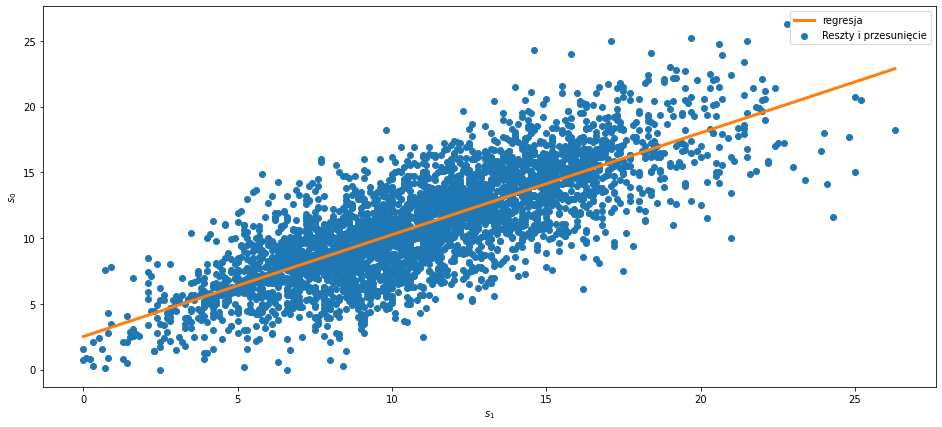

In [117]:
from sklearn.linear_model import LinearRegression
# t = np.arange(1,100)

# vals = [1, 1, 1]
# for i in range(3, 1003):
#     vals += [0.27 * vals[i-3] - 0.35 * vals[i-2] + 1 * vals[i-1] + 0.3*np.random.randn()]
# s = pd.Series(vals[3:])
s = df["Seria"]

y = s.to_numpy()
x = s.to_numpy()
lr = LinearRegression().fit(
    X=x.reshape(-1, 1), y=y)
a, b = lr.coef_, lr.intercept_
line = ([min(x), max(x)], [a*min(x) + b, a*max(x) + b])

fig, ax = plt.subplots(figsize=(16, 7))
ax.scatter(x, y, label="Reszty i przesunięcie")
ax.plot(*line, label="regresja", color="#ff7f0e", lw=3)
ax.set_xlabel("$s_{1}$")
ax.set_ylabel("$s_{0}$")
ax.legend();

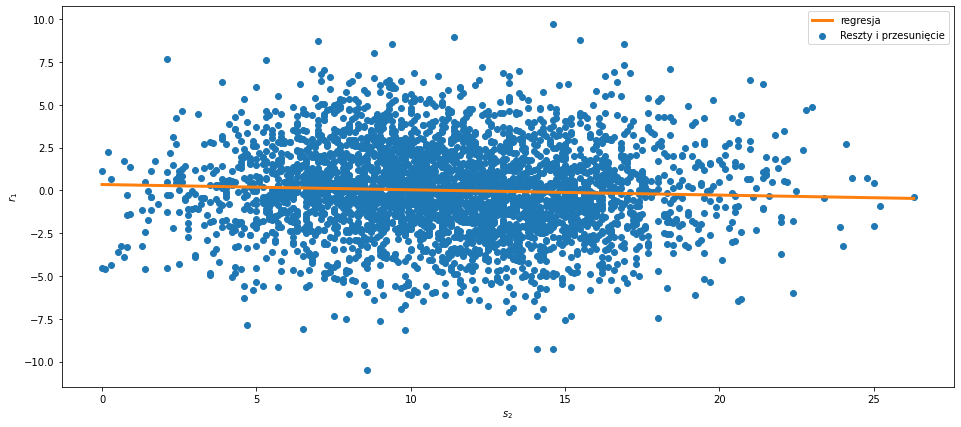

In [118]:
y = (lr.predict(x.reshape(-1, 1)) - y)[1:]
x = s.iloc[:-2].to_numpy()
lr = LinearRegression().fit(
    X=x.reshape(-1, 1), y=y)
a, b = lr.coef_, lr.intercept_
line = ([min(x), max(x)], [a*min(x) + b, a*max(x) + b])

fig, ax = plt.subplots(figsize=(16, 7))
ax.scatter(x, y, label="Reszty i przesunięcie")
ax.plot(*line, label="regresja", color="#ff7f0e", lw=3)
ax.set_xlabel("$s_{2}$")
ax.set_ylabel("$r_{1}$")
ax.legend();

In [20]:
fit_res.get_prediction(dynamic=5000, end=9998).predicted_mean

/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2290: ValueWarning:

Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.



5000     0.000000
5001     0.207807
5002    -0.068479
5003    -0.203894
5004    -0.139800
           ...   
14994    0.259798
14995    0.259798
14996    0.259798
14997    0.259798
14998    0.259798
Name: predicted_mean, Length: 9999, dtype: float64

/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



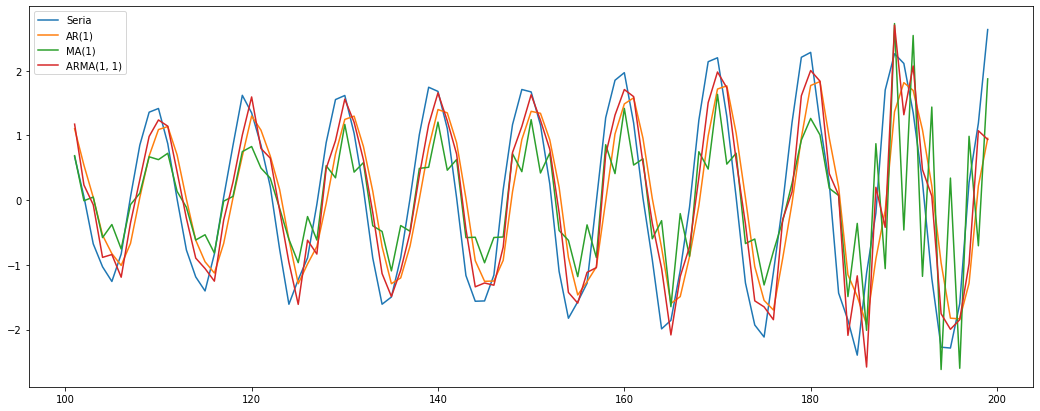

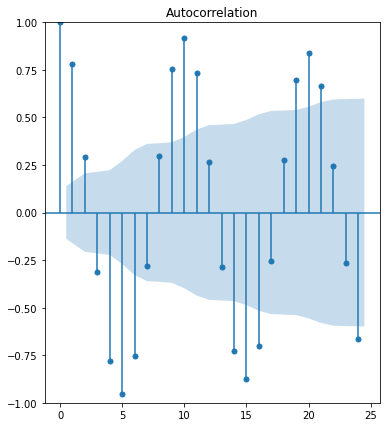

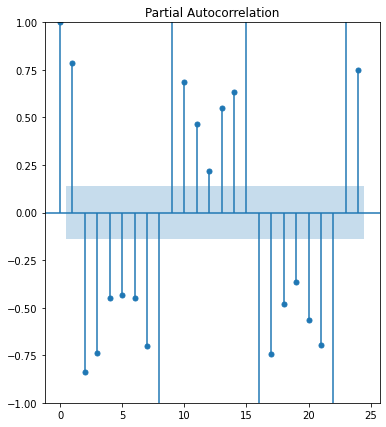

In [63]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
df = pd.read_csv("../data/Meteorology/daily-min-temperatures.csv")

# df["Date"] = pd.to_datetime(df['Date'])
# # df = df.set_index("Date")
# df = df.drop(columns="Date")
# df = df.iloc[:5000]
# df = df.rename(columns={"Temp": "Seria"})
# w_s = 180

# df["Seria"] = (df["Seria"] - df["Seria"].mean())/df["Seria"].std()

t = np.arange(0, 201)

series = pd.Series(5e-2*t + 2e-2*t*np.sin(0.2*np.pi*t) + 2e-3*t*np.random.rand(len(t)))#, index=pd.date_range('20130101 09:00:00', freq='1d', periods=periods))
series = series.diff().dropna().reset_index(drop=True)

fig, ax = plt.subplots(figsize=(18, 7))
series.iloc[101:].plot(ax=ax, label="Seria");

orders = {"AR(1)": (1, 0, 0), "MA(1)": (0, 0, 1), "ARMA(1, 1)": (1, 0, 1)}
for m_name, ord_ in orders.items():
    fit_res = SARIMAX(
        series.iloc[:100], order=ord_
    ).fit()
    arima = SARIMAX(
        series.iloc[100:], order=ord_
    )
    res = arima.filter(fit_res.params).get_prediction(start=1, end=99).predicted_mean
    res.plot(ax=ax, label=m_name);

ax.legend();

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_acf(series)
fig.set_size_inches(6, 7)
plt.show();
fig = plot_pacf(series)
fig.set_size_inches(6, 7)
plt.show();


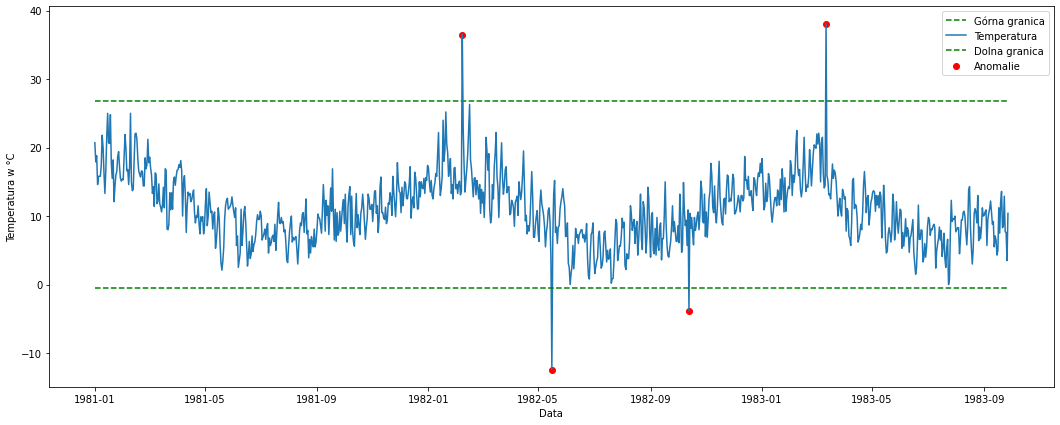

In [40]:
max_ = 1000
y = [0] * max_
x = 2*np.random.randn(max_) + 150
x = x.tolist()

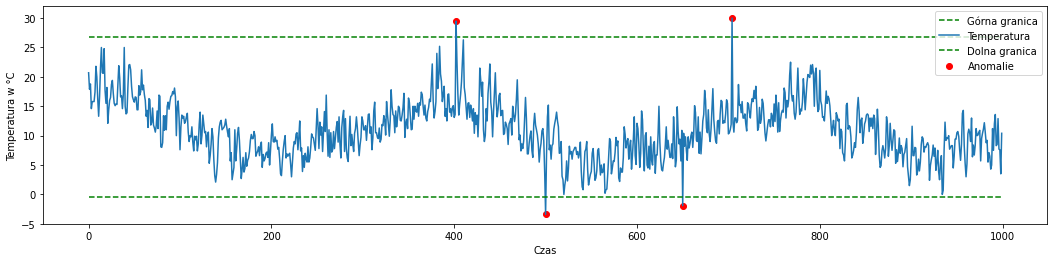

In [81]:

df = pd.read_csv("../data/Meteorology/daily-min-temperatures.csv")

df["Date"] = pd.to_datetime(df['Date'])
# df = df.set_index("Date")
df = df.drop(columns="Date")
df = df.iloc[:1000]
min_, max_ = min(df["Temp"]), max(df["Temp"])
df.iloc[402] += 10
df.iloc[704] += 17
df.iloc[500] -= 8
df.iloc[650] -= 15

fig, ax = plt.subplots(figsize=(18, 4))
ax.plot(df.iloc[[0, 999]].index, [max_ + 0.5]*2, label="Górna granica", c="g", linestyle="--")
ax.plot(df.index, df["Temp"], label="Temperatura")
ax.plot(df.iloc[[0, 999]].index, [min_ - 0.5]*2, label="Dolna granica", c="g", linestyle="--")
ax.scatter(df.index[[402, 500, 650, 704]], df.iloc[[402, 500, 650, 704]], c="r", label="Anomalie")
ax.set_ylim(-5, 32)
ax.set_xlabel("Czas")
ax.set_ylabel("Temperatura w °C")
ax.legend(loc="upper right");

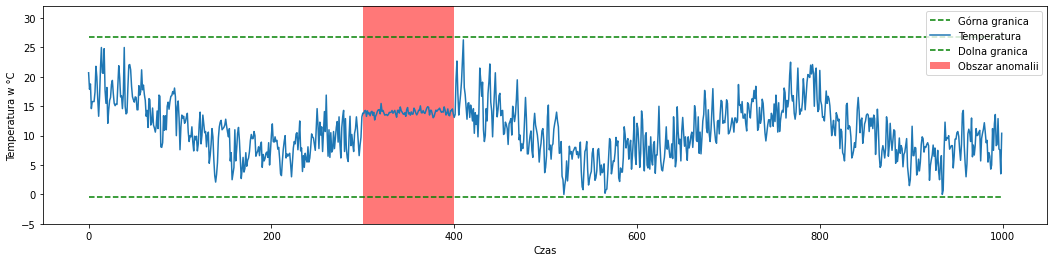

In [82]:
from matplotlib import patches

df = pd.read_csv("../data/Meteorology/daily-min-temperatures.csv")

df["Date"] = pd.to_datetime(df['Date'])
# df = df.set_index("Date")
df = df.drop(columns="Date")
df = df.iloc[:1000]
min_, max_ = min(df["Temp"]), max(df["Temp"])
df.iloc[300:400] = 14 + 0.5*np.random.randn(100, 1)

fig, ax = plt.subplots(figsize=(18, 4))
ax.plot(df.iloc[[0, 999]].index, [max_ + 0.5]*2, label="Górna granica", c="g", linestyle="--")
ax.plot(df.index, df["Temp"], label="Temperatura")
ax.plot(df.iloc[[0, 999]].index, [min_ - 0.5]*2, label="Dolna granica", c="g", linestyle="--")
# ax.scatter(df.iloc[300:400].index, df.iloc[300:400], c="r", label="Anomalie")
rect = patches.Rectangle((df.index[300], -15), 100, 60, linewidth=0, color='#FF101090', label="Obszar anomalii")
ax.add_patch(rect)
ax.set_ylim(-5, 32)
ax.set_xlabel("Czas")
ax.set_ylabel("Temperatura w °C")
ax.legend(loc="upper right");

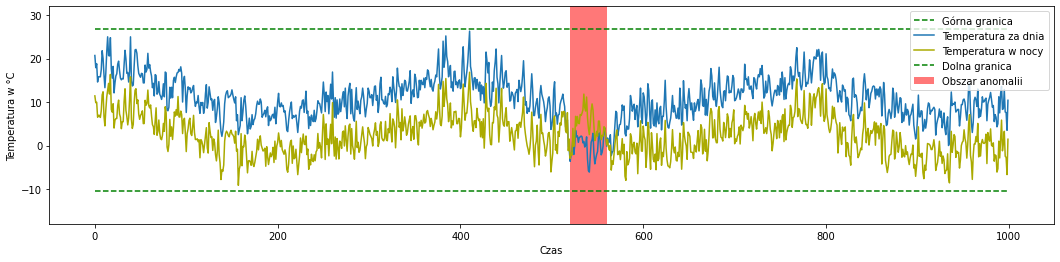

In [83]:
df = pd.read_csv("../data/Meteorology/daily-min-temperatures.csv")

df["Date"] = pd.to_datetime(df['Date'])
# df = df.set_index("Date")
df = df.drop(columns="Date")
df = df.iloc[:1000]
min_, max_ = min(df["Temp"]), max(df["Temp"])
df["Temp2"] = df["Temp"] + 1.1 * np.random.randn(df.shape[0]) - 9
df["Temp2"].iloc[500:580] += [i / 3.5 for i in range(40)] + [i / 3.5 for i in reversed(range(40))]
df["Temp"].iloc[500:580] -= [i / 5.5 for i in range(40)] + [i / 5.5 for i in reversed(range(40))]
# df.iloc[300:400] = 14 + 0.5*np.random.randn(100, 1)

fig, ax = plt.subplots(figsize=(18, 4))
ax.plot(df.iloc[[0, 999]].index, [max_ + 0.5]*2, label="Górna granica", c="g", linestyle="--")
ax.plot(df.index, df["Temp"], label="Temperatura za dnia")
ax.plot(df.index, df["Temp2"], label="Temperatura w nocy", c="#aaaa00")
ax.plot(df.iloc[[0, 999]].index, [min_ - 10.5]*2, label="Dolna granica", c="g", linestyle="--")
# ax.scatter([df.iloc[510:570].index]*2, df.iloc[510:570], c="r", label="Anomalie")
rect = patches.Rectangle((df.index[520], -20), 40, 60, linewidth=0, color='#FF101090', label="Obszar anomalii")
ax.add_patch(rect)

ax.set_ylim(-18, 32)
ax.set_xlabel("Czas")
ax.set_ylabel("Temperatura w °C")
ax.legend(loc="upper right");